# Test of Doppler lags for the observed oscillations

Following tests are scripted for comprehensive characterization
- convergence to reference orbit with zero lags
- impact of a uniform lag in the Doppler (range rate) data
- impact of light-time lags, i.e., radial acceleration and light time
- impact of light-time lags times a scale factor


In [1]:
from astropy import units as u
sampling_interval = 1*u.hour
tracking_period = 30*u.day

In [2]:
from astropy import constants as const
from astropy import visualization
from astropy.coordinates import solar_system_ephemeris

from poliastro.util import norm
from poliastro.twobody.sampling import EpochsArray

import numpy as np
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sim.stations import dss25, dss34
from sim.tracking import Tracking
from sim.util import orbit_from_horizons, make_epochs
from sim.util import describe_orbit, describe_trajectory, plot_residual, plot_swings
from sim.fitorbit import OrbitFitter

def plots(epochs, residual, title, ylab):
    plot_residual(epochs, residual, title, 'Residual ' + ylab)
    try:
        plot_swings(epochs, residual, None, 'Residual swings ' + ylab)
    except ValueError:
        # no swings identified
        pass

def fitv(ref_orbit, ref_stations, epochs, sim_meas, title, _trace=False):
    fitter = OrbitFitter(ref_orbit, ref_stations, trace=_trace)
    fitter.fit_doppler_data(epochs, sim_meas)
    print(fitter.report())
    print('Time elapsed (hh:mm:ss.ms) {}'.format(fitter.runtime))
    describe_orbit(fitter.orbit)
    plots(epochs, fitter.result.residual, title, 'doppler (m/s)')
    return fitter

def reusefitv(fitsolution, epochs, sim_meas, title):
    residual = fitsolution.doppler_residual(epochs, sim_meas)
    plots(epochs, residual, title, 'doppler (m/s)')
    return residual

In [3]:
solar_system_ephemeris.set("de440")
goldstone_end = Tracking.NEAR_GOLDSTONE_END.value

near_goldstone_orbit = orbit_from_horizons("NEAR", goldstone_end)
describe_orbit(near_goldstone_orbit)


::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.97266698121356 deg
Eccentricity: 1.813357091534396
Semilatus rectum: 19437.250829758486 km
Semimajor axix: -8494.322039490264 km
Periapse radius: 6908.917068596319 km , altitude: 530.7804685963192 km


In [4]:
canberra_start = Tracking.NEAR_CANBERRA_START.value
canberra_end = canberra_start + tracking_period
epochs = make_epochs(canberra_start, canberra_end, sampling_interval)
print("Start and end:", epochs[0], epochs[-1], "[", epochs.size, "]")

near_extended_ephem = near_goldstone_orbit.to_ephem(EpochsArray(epochs))
describe_trajectory(near_extended_ephem, dss34)

Start and end: 1998-01-23 09:53:55.600 1998-02-22 08:53:55.600 [ 720 ]

::TRAJECTORY::
Start and end ranges: 99245.53506879517 km 17847092.770730775 km
Start and end radial speeds: 7.3215953575806205 km / s 6.742039221004901 km / s
Closest: 73145.67731807531 km speed 7.5891622264313146 km / s  at  1998-01-23 09:53:55.600
Deflection: 0.457927625040083 deg


In [5]:
vdata_ref = []
vlags = []
vlags_full = []
vdata_constvlags = []
vdata_ltlags_full = []
vdata_ltlags = []
vdata_scaledlags = []

scalefactor = 0.1
first_vlag = None

for e in epochs[:-1]:
    ref_r, ref_rr, ref_ra, ref_rs = dss34.range_rate_accel(near_extended_ephem, e)
    #print(e.strftime("%H:%M:%S"),
         #ref_r.to_value(u.km),
         #ref_ra.to_value(u.m/(u.s*u.s)),
         #ref_rs.to_value(u.m/(u.s*u.s)),
         #(ref_ra+ref_rs).to_value(u.m/(u.s*u.s)),
         #)

    vlag_full = ref_ra*ref_r/const.c
    vlag = (ref_ra+ref_rs)*ref_r/const.c

    if first_vlag is None:
        first_vlag = vlag

    vlags.append(vlag)
    vlags_full.append(vlag_full)

    vdata_ref.append([ref_rr])
    vdata_constvlags.append([ref_rr - first_vlag])
    vdata_ltlags_full.append([ref_rr - vlag_full])
    vdata_ltlags.append([ref_rr - vlag])
    vdata_scaledlags.append([ref_rr - scalefactor*vlag])

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 8
    # data points      = 719
    # variables        = 6
    chi-square         = 1.8917e-21
    reduced chi-square = 2.6531e-24
    Akaike info crit   = -39025.8739
    Bayesian info crit = -38998.4067
##  Warning: uncertainties could not be estimated:
    a:     at initial value
    ecc:   at initial value
    inc:   at initial value
    nu:    at initial value
    raan:  at initial value
    argp:  at initial value
[[Variables]]
    a:    -8494322.04 (init = -8494322)
    ecc:   1.81335709 (init = 1.813357)
    inc:   1.88447854 (init = 1.884479)
    nu:   -1.83942476 (init = -1.839425)
    raan:  1.54005925 (init = 1.540059)
    argp:  2.53325839 (init = 2.533258)
Time elapsed (hh:mm:ss.ms) 0:00:29.840457

::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.97266698121356 deg
Eccentricity: 1.813357091534396
Semilatus rectum: 19437250.829758488 m
Semimajor axix: -8494322.039490264 m
Periapse radius: 690

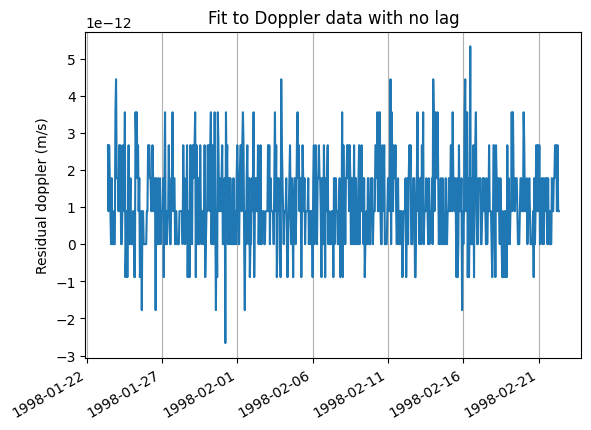

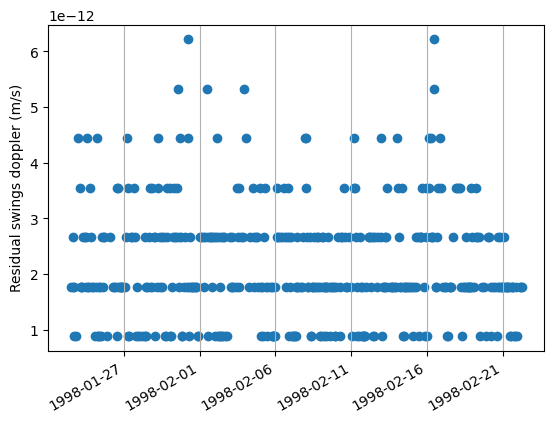

In [6]:
fitv(near_goldstone_orbit, [dss34], epochs[:-1], vdata_ref, "Fit to Doppler data with no lag")

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 15
    # data points      = 719
    # variables        = 6
    chi-square         = 0.03759571
    reduced chi-square = 5.2729e-05
    Akaike info crit   = -7076.42448
    Bayesian info crit = -7048.95731
##  Warning: uncertainties could not be estimated:
    a:     at initial value
    ecc:   at initial value
    inc:   at initial value
    argp:  at initial value
[[Variables]]
    a:    -8494322.04 (init = -8494322)
    ecc:   1.81335709 (init = 1.813357)
    inc:   1.88447854 (init = 1.884479)
    nu:   -1.83946672 (init = -1.839425)
    raan:  1.54000696 (init = 1.540059)
    argp:  2.53324215 (init = 2.533258)
Time elapsed (hh:mm:ss.ms) 0:00:48.846939

::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.97266698121356 deg
Eccentricity: 1.813357091534396
Semilatus rectum: 19437250.829758488 m
Semimajor axix: -8494322.039490264 m
Periapse radius: 6908917.068596319 m , altitude: 530780.4685963197 m
[0.000

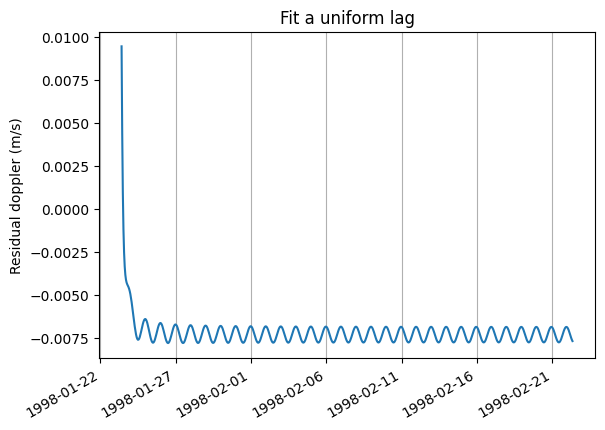

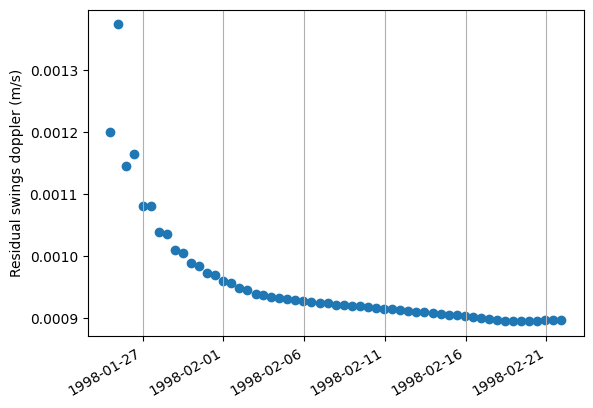

In [7]:
constfitv = fitv(near_goldstone_orbit, [dss34], epochs[:-1], vdata_constvlags, "Fit a uniform lag")

[0.0008959873092351245, 0.0008961973128052136, 0.0008964913789100137, 0.0008966086566530862]


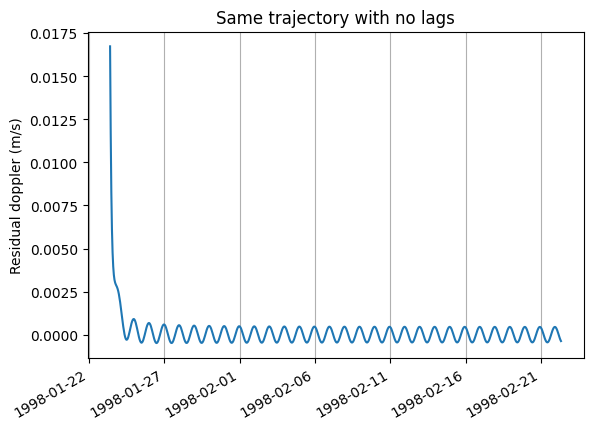

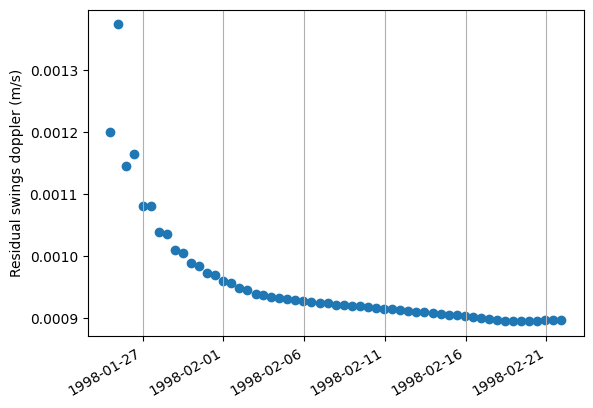

In [8]:
_ = reusefitv(constfitv, epochs[:-1], vdata_ref, "Same trajectory with no lags")

[0.0008936378179669191, 0.0008965751998601945, 0.0008940501476928375, 0.0008967112776758768]


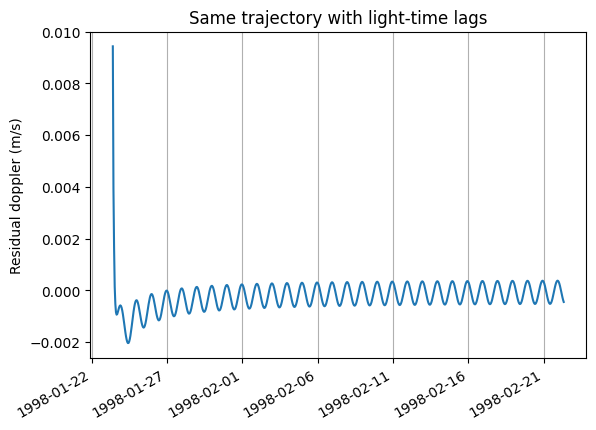

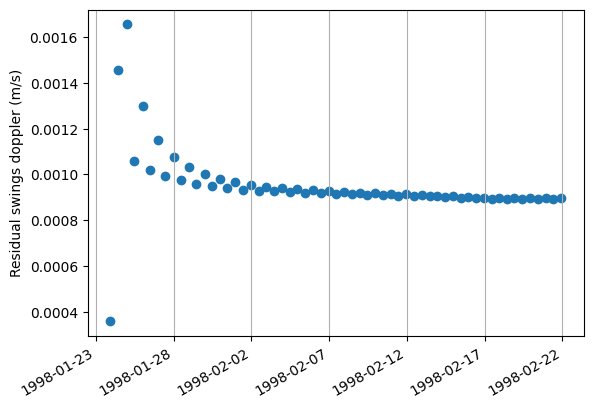

In [9]:
_ = reusefitv(constfitv, epochs[:-1], vdata_ltlags, "Same trajectory with light-time lags")

[0.9499183376355802, 0.9675417029733069, 0.9851236550817433, 1.002649456435023]


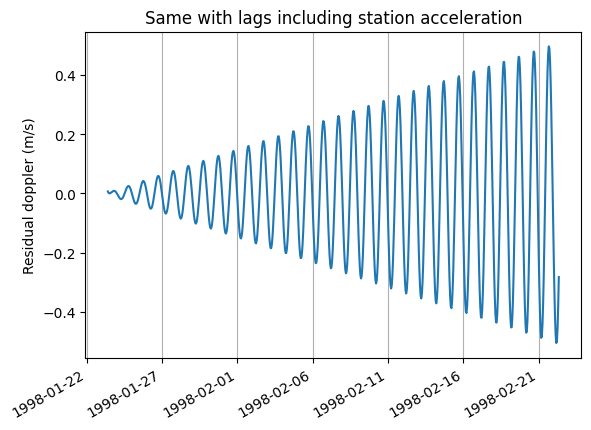

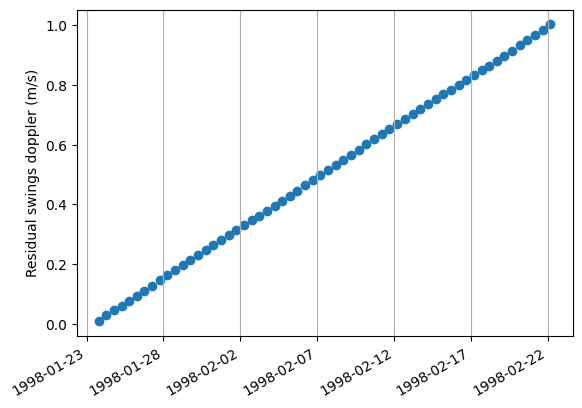

In [10]:
_ = reusefitv(constfitv, epochs[:-1], vdata_ltlags_full, "Same with lags including station acceleration")

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 15
    # data points      = 719
    # variables        = 6
    chi-square         = 1.8990e-04
    reduced chi-square = 2.6634e-07
    Akaike info crit   = -10878.5994
    Bayesian info crit = -10851.1322
##  Warning: uncertainties could not be estimated:
    a:     at initial value
    ecc:   at initial value
    inc:   at initial value
    argp:  at initial value
[[Variables]]
    a:    -8494322.04 (init = -8494322)
    ecc:   1.81335709 (init = 1.813357)
    inc:   1.88447854 (init = 1.884479)
    nu:   -1.83945089 (init = -1.839425)
    raan:  1.54004127 (init = 1.540059)
    argp:  2.53325285 (init = 2.533258)
Time elapsed (hh:mm:ss.ms) 0:00:49.001798

::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.97266698121356 deg
Eccentricity: 1.813357091534396
Semilatus rectum: 19437250.829758488 m
Semimajor axix: -8494322.039490264 m
Periapse radius: 6908917.068596319 m , altitude: 530780.4685963197 m
[0.000

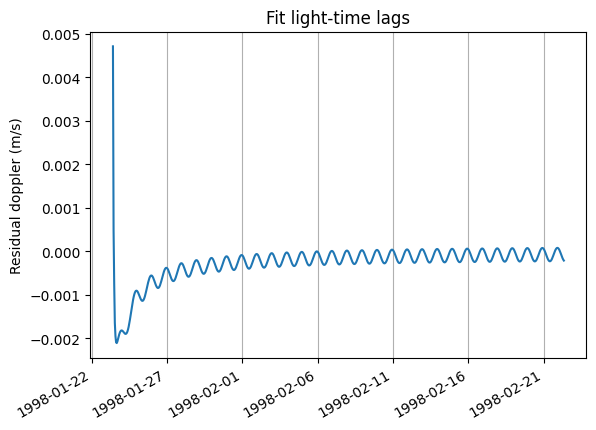

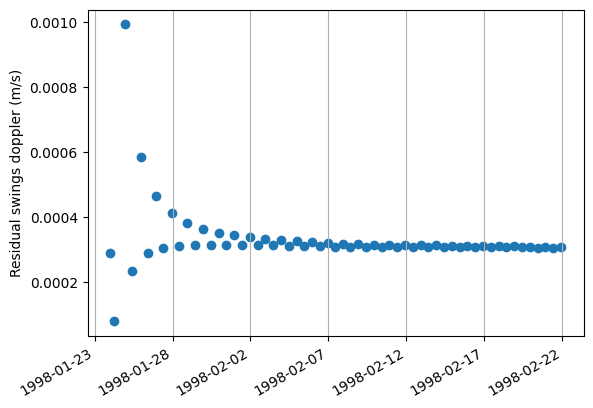

In [11]:
ltfitv = fitv(near_goldstone_orbit, [dss34], epochs[:-1], vdata_ltlags, "Fit light-time lags")

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 15
    # data points      = 719
    # variables        = 6
    chi-square         = 1.8990e-06
    reduced chi-square = 2.6634e-09
    Akaike info crit   = -14189.7212
    Bayesian info crit = -14162.2540
##  Warning: uncertainties could not be estimated:
    a:     at initial value
    ecc:   at initial value
    inc:   at initial value
    nu:    at initial value
    raan:  at initial value
    argp:  at initial value
[[Variables]]
    a:    -8494322.04 (init = -8494322)
    ecc:   1.81335709 (init = 1.813357)
    inc:   1.88447854 (init = 1.884479)
    nu:   -1.83942737 (init = -1.839425)
    raan:  1.54005746 (init = 1.540059)
    argp:  2.53325783 (init = 2.533258)
Time elapsed (hh:mm:ss.ms) 0:00:48.917226

::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.97266698121356 deg
Eccentricity: 1.813357091534396
Semilatus rectum: 19437250.829758488 m
Semimajor axix: -8494322.039490264 m
Periapse radius: 69

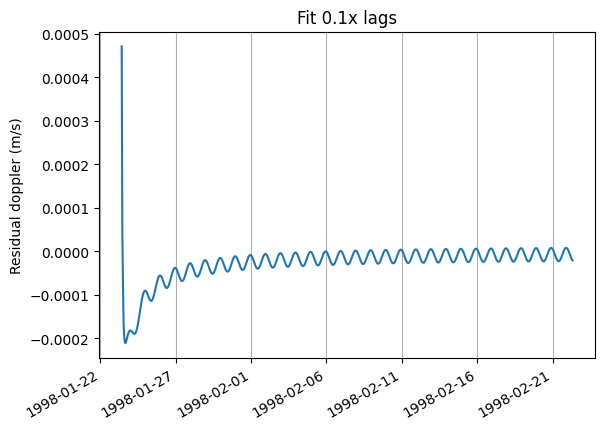

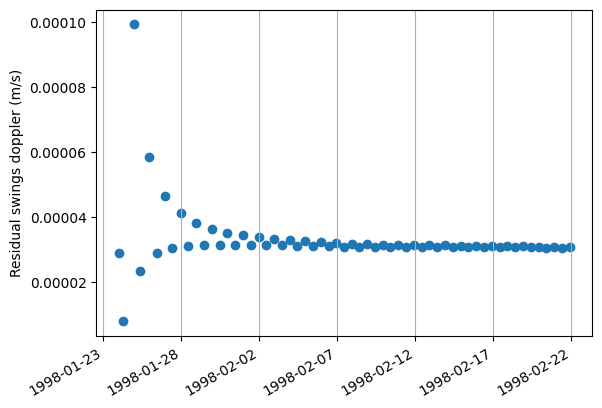

In [12]:
scaledfitv = fitv(near_goldstone_orbit, [dss34], epochs[:-1], vdata_scaledlags, f'Fit {scalefactor}x lags')

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 719
    # variables        = 6
    chi-square         = 7.84327991
    reduced chi-square = 0.01100039
    Akaike info crit   = -3236.58886
    Bayesian info crit = -3209.12169
##  Warning: uncertainties could not be estimated:
    a:     at initial value
    ecc:   at initial value
    inc:   at initial value
[[Variables]]
    a:    -8494322.04 (init = -8494322)
    ecc:   1.81335709 (init = 1.813357)
    inc:   1.88447854 (init = 1.884479)
    nu:   -1.83934636 (init = -1.839425)
    raan:  1.54105922 (init = 1.540059)
    argp:  2.53289239 (init = 2.533258)
Time elapsed (hh:mm:ss.ms) 0:01:07.835776

::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.97266698121356 deg
Eccentricity: 1.813357091534396
Semilatus rectum: 19437250.829758488 m
Semimajor axix: -8494322.039490264 m
Periapse radius: 6908917.068596319 m , altitude: 530780.4685963197 m
[0.44089605488828454, 0.4570785047

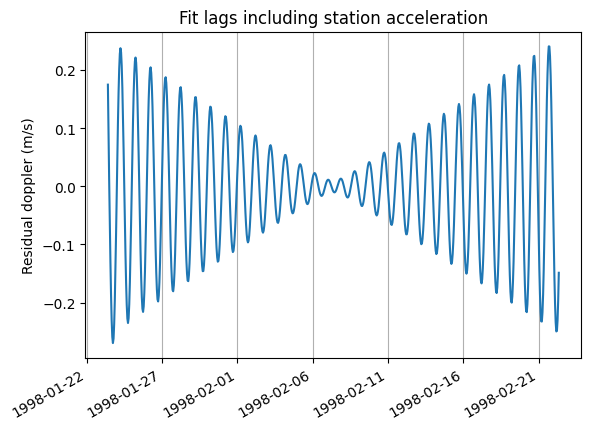

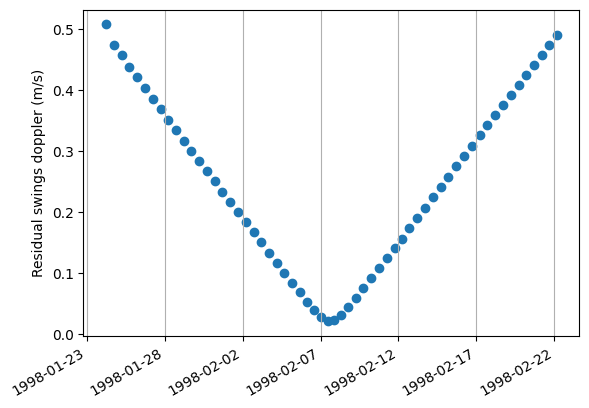

In [13]:
fltfitv = fitv(near_goldstone_orbit, [dss34], epochs[:-1], vdata_ltlags_full, "Fit lags including station acceleration")

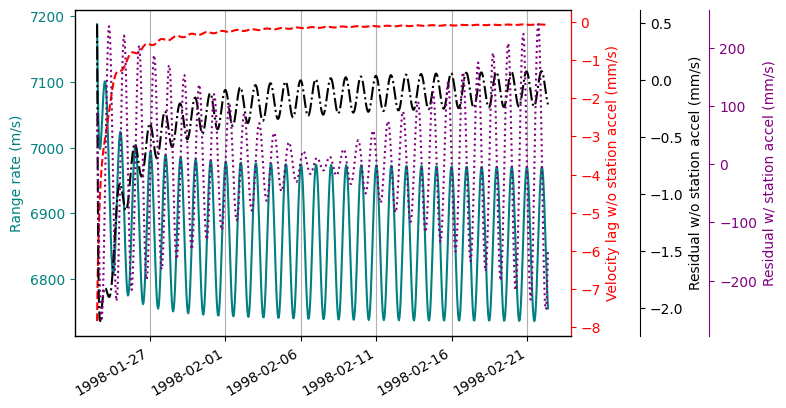

In [14]:
with visualization.time_support():
    fig, ax = plt.subplots()
    plt.xlabel('')
    plt.grid(axis='x')

    if tracking_period > 5*u.day:
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    else:
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))

    ax.set_ylabel('Range rate (m/s)', color = "teal")
    ax.spines['left'].set(color="teal")
    ax.tick_params(axis="y", colors="teal")

    ax2 = ax.twinx()
    ax2.set_ylabel('Velocity lag w/o station accel (mm/s)', color = "red")
    ax2.spines['right'].set(color="red")
    ax2.tick_params(axis="y", colors="red")

    ax3 = ax.twinx()
    ax3.set_ylabel('Residual w/o station accel (mm/s)', color = "black")
    ax3.spines['right'].set_position(('outward', 50))

    ax4 = ax.twinx()
    ax4.set_ylabel('Residual w/ station accel (mm/s)', color = "purple")
    ax4.spines['right'].set(position=('outward', 100), color = "purple")
    ax4.tick_params(axis="y", colors="purple")

    #h1 = ax4.axhline(y = 929, linestyle = "dashed", color='black', label="Earth SOI")
    #h2 = ax4.axhline(y = 384.4, linestyle = "dotted", color='black', label="Distance to moon")

    p1, = ax.plot(epochs[2:], [v[0].to_value(u.m/u.s) for v in vdata_ref[1:]],
                  color="teal", label="Range rate")
    p2, = ax2.plot(epochs[2:], [v.to_value(u.mm/u.s) for v in vlags[1:]],
                   linestyle = "dashed", color="red", label="lag w/o station accel")

    p3, = ax3.plot(epochs[2:], [1e3*v for v in ltfitv.result.residual[1:]],
                   linestyle='-.', color="black", label="residual w/o station accel")
    p4, = ax4.plot(epochs[2:], [1e3*v for v in fltfitv.result.residual[1:]],
                   linestyle=":", color="purple", label="residual")

    #ax.legend(handles=[p1, p4, p2, p3], loc="lower right", ncol=2)
    plt.gcf().autofmt_xdate()

    plt.savefig(f'near_sim_postencounter_doppler-{int(tracking_period.to_value(u.day))}d.pdf', bbox_inches='tight')